## import the libraries 

In [1]:
import uproot3
import dask.dataframe as dd
import time
from dask import delayed
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
import os

pd.pandas.set_option('display.max_columns',None)

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


## Check if jupyter notebook or script

In [2]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [3]:
if in_ipynb():
    print("In IPython")
    TrainConfig="Configs/MultiClassification_XGBoost_endcap"
    exec("import "+TrainConfig.replace("/", ".")+" as Conf")
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

{'IPKernelApp': {'connection_file': '/scratch/rchudasa/.local/share/jupyter/runtime/kernel-e1824a72-2059-40c1-baca-c4c7fd84b442.json'}, 'InteractiveShellApp': {'extensions': <LazyConfigValue value=['sparkmonitor.kernelextension', 'swankernelenv']>}}
In IPython


2022-10-20 12:35:48.548252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [4]:
import os
os.system("")
os.system("mkdir -p " + Conf.OutputDirName)

0

### Function to return pandas dataframe from root file 

In [5]:
def get_pandasDataFrame(process,cat,path,fileName,treeName,branches,selection):
    print(selection)
    eventsPhoton  = uproot3.open(path+fileName)[treeName]
    #pd_dataframe  = eventsPhoton.pandas.df(branches=branches)
    pd_dataframe  = eventsPhoton.pandas.df(branches=branches).query(selection)
    pd_dataframe['Class'] = process
    pd_dataframe['Category'] = cat

    
    print(pd_dataframe.shape)
    return pd_dataframe

### Append pandas dataframe to dask framework using delayed to reduce the computing time

In [6]:
dfs= []
start = time.time()
for process in Conf.processes:
    path = Conf.baseInputPath
    pr = process['Class']
    cat = process['category']
    fileName  = process['fileName']
    treeName  = process['treeName']
    selection = process['selection']
    print(path,fileName,treeName)
    dfs.append(delayed(get_pandasDataFrame(pr,cat,path,fileName,treeName,branches=Conf.branches,selection=selection)))
end  = time.time()
print("Execution time is", end-start)


/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_signal_bsMMG_endcap.root genMatchedBMMGSCTree
(scEt>4) & (scEt<15) & abs(scEta)>1.566 & abs(scEta)<2.4
(72371, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_qcd20To30EmEnriched_endcap.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)>1.566 & abs(scEta) < 2.4
(123895, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_bkg_flat_pi0_endcap.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)>1.566 & abs(scEta) < 2.4
(17291, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ data_2018D_endcap.root dataAllSCTree
(scEt>4) & (scEt<15) & abs(scEta)>1.566 & abs(scEta) < 2.4
(382178, 26)
Execution time is 7.4962382316589355


In [7]:
daskframe = dd.from_delayed(dfs)
final_df = daskframe.compute()
final_df.reset_index(inplace=True, drop=True)

In [8]:
final_df.head()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category
0,17.124434,5.111846,1.879032,-0.819066,0.025572,1.000000e+09,0.0,0.885800,0.017902,0.000222,0.775372,0.710296,1.000000,0.224628,3.462248,4.099676,4.324628,7.889235,7.889235,1.815070,3.897044,7.754038,9.133965,12.619382,Signal,0
1,24.669886,9.745676,1.580388,1.304956,0.003096,2.240261e+00,0.0,1.000000,0.016174,-0.000093,0.888417,0.874403,1.000000,0.088652,0.000000,0.000000,0.000000,0.000000,0.833241,0.506073,2.823912,5.028801,8.425012,9.865065,Signal,0
2,21.999235,6.611433,-1.871969,1.976124,0.010102,0.000000e+00,1.0,1.000000,0.020907,-0.000072,0.722597,0.616102,0.946634,0.147213,0.000000,0.000000,0.000000,0.000000,0.000000,0.459449,0.459449,2.801852,5.727080,9.649850,Signal,0
3,25.879095,8.798177,-1.741803,0.559429,0.013409,1.000000e+09,0.0,0.838818,0.036833,-0.000059,0.479300,0.119227,0.906453,0.333189,2.683528,2.683528,4.418558,4.606974,4.606974,7.305373,7.305373,9.594089,14.489732,17.313068,Signal,0
4,30.303923,11.885474,1.588221,-2.074802,0.006721,0.000000e+00,1.0,0.872347,0.023500,-0.000052,0.741974,0.692424,1.000000,0.123380,0.000000,2.284233,3.315942,3.678190,4.284877,0.000000,3.213417,5.203255,10.654004,12.805341,Signal,0


In [9]:
final_df.tail()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category
595730,21.819363,4.360522,-2.293216,-2.987154,1.450877e-02,0.000000,1.0,1.000000,0.021476,-0.000126,0.732541,0.634888,1.0,0.149465,0.000000,0.650333,2.960377,2.960377,4.521935,0.000000,1.720346,4.433455,13.262613,15.521695,Data,3
595731,14.774988,4.527277,-1.851617,0.940519,3.446057e-08,2.144976,0.0,1.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.287734,0.287734,0.287734,0.762067,0.000000,1.384811,5.945653,11.434899,15.984566,Data,3
595732,18.107315,7.038714,-1.597921,-0.308120,2.765449e-02,1.514664,0.0,0.673394,0.020029,0.000219,0.774760,0.709278,1.0,0.140767,1.591181,1.591181,2.226322,2.531738,2.531738,2.849689,14.940892,16.437456,23.969360,30.368395,Data,3
595733,20.639601,6.686189,1.792982,2.906240,2.945123e-02,0.028056,0.0,0.592728,0.018401,0.000017,0.783421,0.723547,1.0,0.077481,0.000000,0.000000,2.316088,3.107949,5.722239,4.825342,15.867325,21.998638,32.717403,38.001743,Data,3
595734,18.381420,5.039147,1.967909,3.017420,4.355451e-03,0.189224,0.0,0.591488,0.003915,0.000016,0.541817,0.154360,1.0,0.452996,1.360569,1.360569,1.360569,1.855854,2.316088,1.005273,9.559507,21.308096,32.484581,35.949738,Data,3


In [10]:
final_df.shape

(595735, 26)

## Prepare the dataframe for reweighting and finding weights  

In [11]:
final_df['Class'].unique()

array(['Signal', 'QCD', 'Pi0', 'Data'], dtype=object)

In [12]:
final_df["NewWt"]=1
final_df["xsecwt"]=1


In [13]:
final_df.head()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category,NewWt,xsecwt
0,17.124434,5.111846,1.879032,-0.819066,0.025572,1.000000e+09,0.0,0.885800,0.017902,0.000222,0.775372,0.710296,1.000000,0.224628,3.462248,4.099676,4.324628,7.889235,7.889235,1.815070,3.897044,7.754038,9.133965,12.619382,Signal,0,1,1
1,24.669886,9.745676,1.580388,1.304956,0.003096,2.240261e+00,0.0,1.000000,0.016174,-0.000093,0.888417,0.874403,1.000000,0.088652,0.000000,0.000000,0.000000,0.000000,0.833241,0.506073,2.823912,5.028801,8.425012,9.865065,Signal,0,1,1
2,21.999235,6.611433,-1.871969,1.976124,0.010102,0.000000e+00,1.0,1.000000,0.020907,-0.000072,0.722597,0.616102,0.946634,0.147213,0.000000,0.000000,0.000000,0.000000,0.000000,0.459449,0.459449,2.801852,5.727080,9.649850,Signal,0,1,1
3,25.879095,8.798177,-1.741803,0.559429,0.013409,1.000000e+09,0.0,0.838818,0.036833,-0.000059,0.479300,0.119227,0.906453,0.333189,2.683528,2.683528,4.418558,4.606974,4.606974,7.305373,7.305373,9.594089,14.489732,17.313068,Signal,0,1,1
4,30.303923,11.885474,1.588221,-2.074802,0.006721,0.000000e+00,1.0,0.872347,0.023500,-0.000052,0.741974,0.692424,1.000000,0.123380,0.000000,2.284233,3.315942,3.678190,4.284877,0.000000,3.213417,5.203255,10.654004,12.805341,Signal,0,1,1


In [14]:
Classes=Conf.Classes

## Divide the dataframe for training and testing
adapted from LPC Egamma ID tutorial

In [15]:
index = final_df.index
from sklearn.model_selection import train_test_split
TrainIndices=[]
TestIndices=[]
for myclass in Classes:
    condition = final_df["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=0.25, random_state=42, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

final_df.loc[TrainIndices,'Dataset'] = "Train"
final_df.loc[TestIndices,'Dataset'] = "Test"

final_df.loc[TrainIndices,'TrainDataset'] = 1
final_df.loc[TestIndices,'TrainDataset'] = 0

In [16]:
#final_df[(final_df['Dataset']=='Train') & (final_df['Class']=='bkg')].shape

In [17]:
#final_df[(final_df['Dataset']=='Train') & (final_df['Class']=='signal')].shape

Text(0.5, 1.0, 'Number of samples')

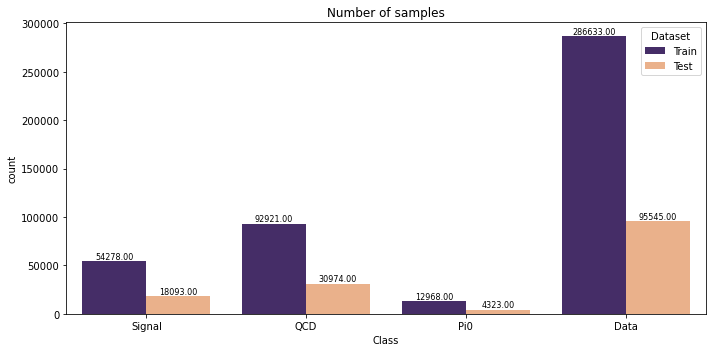

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

In [17]:
ClassColors = Conf.ClassColors

In [18]:
def MyBins(lower,upper,step): return np.arange(lower,upper,step).tolist() 
def prGreen(prt): print("\033[92m {}\033[00m" .format(prt))


def MakeFeaturePlots(df_final,features,feature_bins,Set="Train",OutputDirName='Figures',cat='Category',label=[""],weight="NewWt",log=False,locate=[""]):
    fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
    #fig, axes = plt.subplots(1, 1, figsize=(len(features)*5, 5))

    prGreen("Making "+Set+" dataset spectator plots")
    for m in range(len(features)):
        for i,group_df in df_final[df_final['Dataset'] == Set].groupby(cat):
            print(m, i, cat)
            group_df[features[m]].hist(histtype='step',color=ClassColors[i], bins=feature_bins[m], alpha=1,label=label[i], ax=axes[m], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=2)
        axes[m].legend(loc=locate[m])
        axes[m].set_xlabel(features[m])
        if log:
            axes[m].set_yscale("log")
            axes[m].set_ylim([0.0001,1.2])
        axes[m].set_title(features[m]+" ("+Set+" Dataset)")
        plt.savefig(OutputDirName+'/'+features[m]+Set+".png".format(m))




 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category


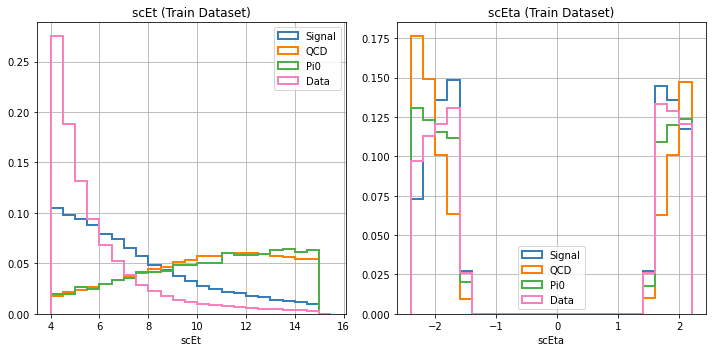

In [19]:
Variables=['scEt','scEta']
VarBins=[MyBins(4,16,0.5), MyBins(-2.4,2.4,0.2)]
loca=['upper right','lower center']
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=False,locate=loca)

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category
2 0 Category
2 1 Category
2 2 Category
2 3 Category
3 0 Category
3 1 Category
3 2 Category
3 3 Category


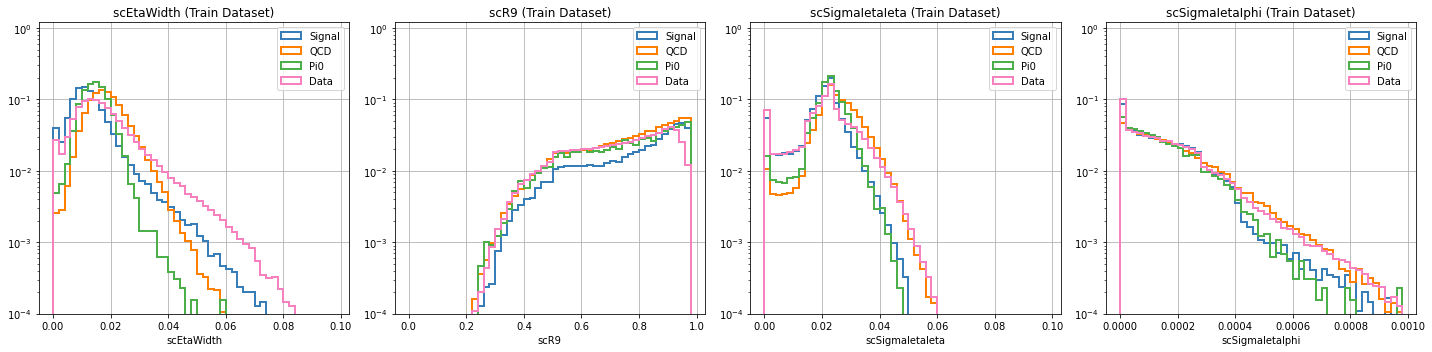

In [20]:
ShowerShape_widths=['scEtaWidth',
          'scR9',
          'scSigmaIetaIeta',
          'scSigmaIetaIphi']
VarBins=[MyBins(0,0.1,0.002), 
        MyBins(0,1,0.02), 
        MyBins(0,0.1,0.002),
        MyBins(0,0.001,0.00002)]
loca=['upper right']*4
MakeFeaturePlots(final_df,ShowerShape_widths,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=True,locate=loca)

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category
2 0 Category
2 1 Category
2 2 Category
2 3 Category
3 0 Category
3 1 Category
3 2 Category
3 3 Category


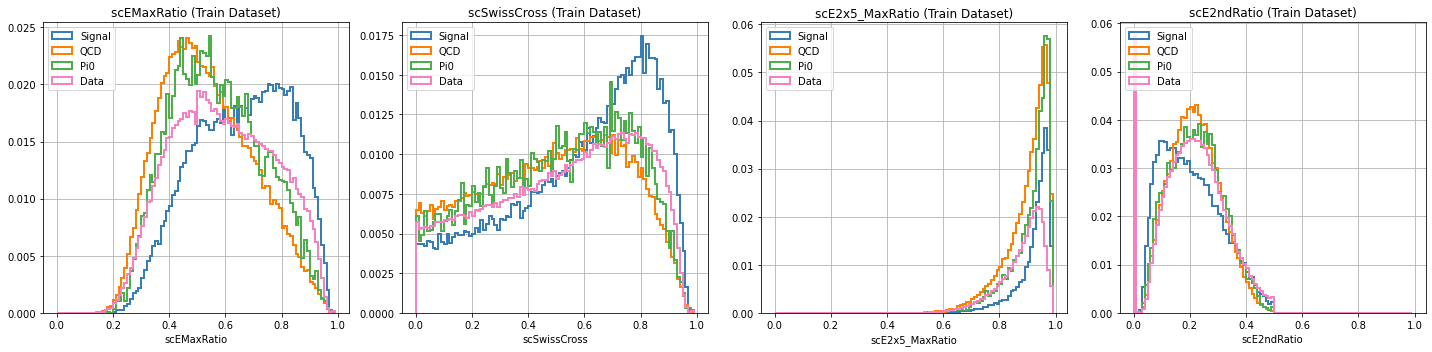

In [21]:
ShowerShape_Ratios=['scEMaxRatio',
          'scSwissCross',
          'scE2x5_MaxRatio',
          'scE2ndRatio']
VarBins=[MyBins(0,1,0.01)]*len(ShowerShape_Ratios)
loca=['upper left']*4
MakeFeaturePlots(final_df,ShowerShape_Ratios,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=False,locate=loca)

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category
2 0 Category
2 1 Category
2 2 Category
2 3 Category


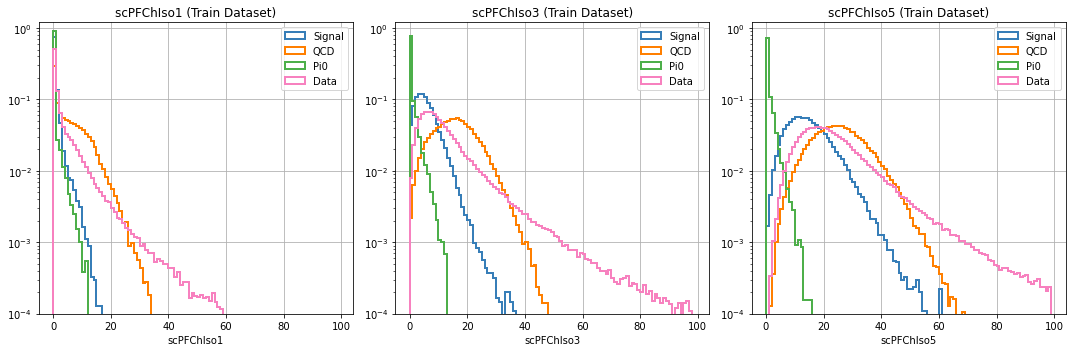

In [22]:
isolation_vars=['scPFChIso1','scPFChIso3','scPFChIso5']
VarBins=[MyBins(0,100,1)]*len(isolation_vars)
loca=['upper right']*3
MakeFeaturePlots(final_df,isolation_vars,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=True,locate=loca)

## Reweighting 

In [37]:
import Tools.ptetaRwt as ptetaRwt

In [38]:
final_df.loc[TrainIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TrainIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="Signal",Classes=Classes)

final_df.loc[TestIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TestIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   #ptw=[4,6,8,10,13,15],etaw=[-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442],
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="Signal",Classes=Classes)

Number of xsec events in bkg for pt 4 to 6 before  weighing = 1166
Number of xsec events in signal for pt 4 to 6 before  weighing = 5766
Number of xsec events in bkg for pt 4 to 6 before  weighing = 757
Number of xsec events in signal for pt 4 to 6 before  weighing = 5766
Number of xsec events in bkg for pt 4 to 6 before  weighing = 38454
Number of xsec events in signal for pt 4 to 6 before  weighing = 5766
Number of xsec events in bkg for pt 6 to 8 before  weighing = 1030
Number of xsec events in signal for pt 6 to 8 before  weighing = 3863
Number of xsec events in bkg for pt 6 to 8 before  weighing = 796
Number of xsec events in signal for pt 6 to 8 before  weighing = 3863
Number of xsec events in bkg for pt 6 to 8 before  weighing = 10215
Number of xsec events in signal for pt 6 to 8 before  weighing = 3863
Number of xsec events in bkg for pt 8 to 10 before  weighing = 949
Number of xsec events in signal for pt 8 to 10 before  weighing = 2183
Number of xsec events in bkg for pt 8 to

Number of xsec events in bkg for pt 4 to 6 before  weighing = 2084
Number of xsec events in signal for pt 4 to 6 before  weighing = 11173
Number of xsec events in bkg for pt 4 to 6 before  weighing = 1312
Number of xsec events in signal for pt 4 to 6 before  weighing = 11173
Number of xsec events in bkg for pt 4 to 6 before  weighing = 48359
Number of xsec events in signal for pt 4 to 6 before  weighing = 11173
Number of xsec events in bkg for pt 6 to 8 before  weighing = 1654
Number of xsec events in signal for pt 6 to 8 before  weighing = 6547
Number of xsec events in bkg for pt 6 to 8 before  weighing = 1166
Number of xsec events in signal for pt 6 to 8 before  weighing = 6547
Number of xsec events in bkg for pt 6 to 8 before  weighing = 13531
Number of xsec events in signal for pt 6 to 8 before  weighing = 6547
Number of xsec events in bkg for pt 8 to 10 before  weighing = 1588
Number of xsec events in signal for pt 8 to 10 before  weighing = 3823
Number of xsec events in bkg for p

Number of events in QCD after  weighing = 138039.0
Number of events in Pi0 after  weighing = 138039.0
Number of events in Data after  weighing = 138038.99999999997
Number of xsec events in bkg for pt 4 to 6 before  weighing = 433
Number of xsec events in signal for pt 4 to 6 before  weighing = 1980
Number of xsec events in bkg for pt 4 to 6 before  weighing = 233
Number of xsec events in signal for pt 4 to 6 before  weighing = 1980
Number of xsec events in bkg for pt 4 to 6 before  weighing = 13113
Number of xsec events in signal for pt 4 to 6 before  weighing = 1980
Number of xsec events in bkg for pt 6 to 8 before  weighing = 325
Number of xsec events in signal for pt 6 to 8 before  weighing = 1340
Number of xsec events in bkg for pt 6 to 8 before  weighing = 265
Number of xsec events in signal for pt 6 to 8 before  weighing = 1340
Number of xsec events in bkg for pt 6 to 8 before  weighing = 3446
Number of xsec events in signal for pt 6 to 8 before  weighing = 1340
Number of xsec ev

Number of xsec events in bkg for pt 4 to 6 before  weighing = 658
Number of xsec events in signal for pt 4 to 6 before  weighing = 3736
Number of xsec events in bkg for pt 4 to 6 before  weighing = 445
Number of xsec events in signal for pt 4 to 6 before  weighing = 3736
Number of xsec events in bkg for pt 4 to 6 before  weighing = 16309
Number of xsec events in signal for pt 4 to 6 before  weighing = 3736
Number of xsec events in bkg for pt 6 to 8 before  weighing = 540
Number of xsec events in signal for pt 6 to 8 before  weighing = 2258
Number of xsec events in bkg for pt 6 to 8 before  weighing = 394
Number of xsec events in signal for pt 6 to 8 before  weighing = 2258
Number of xsec events in bkg for pt 6 to 8 before  weighing = 4474
Number of xsec events in signal for pt 6 to 8 before  weighing = 2258
Number of xsec events in bkg for pt 8 to 10 before  weighing = 520
Number of xsec events in signal for pt 8 to 10 before  weighing = 1307
Number of xsec events in bkg for pt 8 to 10

Number of events in Signal after  weighing = 46013.0
Number of events in QCD after  weighing = 46013.0
Number of events in Pi0 after  weighing = 46013.0
Number of events in Data after  weighing = 46013.00000000001


In [26]:
final_df['NewWt'].unique()

array([1.        , 1.16173032, 5.72657055, 0.63544588, 2.4135255 ,
       0.5799458 , 5.42636986, 1.13154831, 4.57274827, 1.19314206,
       5.5696913 , 2.30031612, 5.36132438, 5.26525424, 0.61665053,
       3.61303462, 1.08364312, 1.1566416 , 2.41830823, 2.39976959,
       2.40743073, 3.95828295, 2.46875   , 2.30409357, 0.61403509,
       5.80978261, 0.63142857, 3.81818182, 0.625     , 3.75048544,
       0.62315996, 1.20323625, 2.41831683, 1.15767635, 0.58609272,
       3.89216684, 2.26238145, 0.61306533, 5.17626527, 5.47619048,
       1.17434472, 5.58362369, 4.94511149, 0.58640777, 1.18533071,
       1.15671642, 1.24657534, 1.18762887, 4.18148148, 5.67781155,
       2.38771186, 5.14106145, 1.8559322 , 4.29028698, 4.91504854,
       3.89963504, 0.63035019, 0.76902174, 0.62875341, 2.51346154,
       2.35962145, 3.95264117, 2.19266055, 3.70491803, 3.76082677,
       1.19563736, 2.24761905, 3.94303797, 3.78106509, 5.73913043,
       1.12055336, 1.2642998 , 1.29376499, 4.12307692, 3.59442

Text(0.5, 1.0, 'Number of samples')

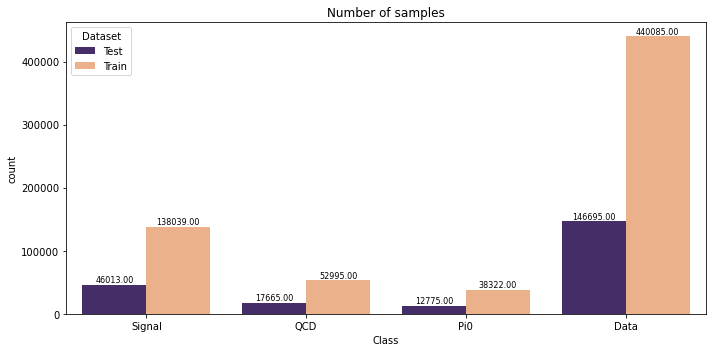

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category


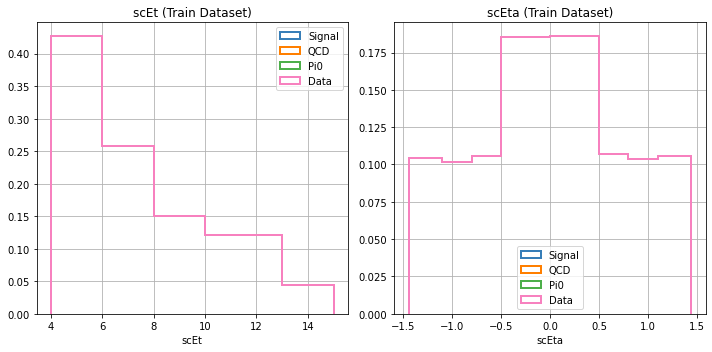

In [42]:
Variables=['scEt','scEta']
#VarBins=[[4,6,8,10,13,15], [-2.4,-2.0,-1.566,1.566,2.0,2.4]]
VarBins=[Conf.ptbins,Conf.etabins]
loca=['upper right','lower center']
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName=Conf.OutputDirName+"/reweighted",label=Classes,log=False,locate=loca)